In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, activations, losses, metrics, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential


import seaborn as sns
import matplotlib.lines as lines

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/Fraud analytics/creditcard.csv")
#df

# Data preprocessing

In [ ]:
# Log transform the Time and Amount features
df['Time'] = np.log1p(df['Time'])
df['Amount'] = np.log1p(df['Amount'])

x = df.drop('Class', axis=1)
y = df['Class']

# # prepare data
# normal_events = df[df['Class'] == 0]
# abnormal_events = df[df['Class'] == 1]

# normal_with_class = normal_events.copy()
# abnormal_with_class = abnormal_events.copy()

# normal_events = normal_events.loc[:, normal_events.columns != 'Class']
# abnormal_events = abnormal_events.loc[:, abnormal_events.columns != 'Class']
# normal_events

In [ ]:
# Scaling the data
norm_df = df.copy()

scaler = MinMaxScaler()
scaler.fit(norm_df)
scaled_data = scaler.transform(norm_df)

scaled_df = pd.DataFrame(data=scaled_data)
scaled_df.columns = df.columns
#scaled_df

In [ ]:
normal_events = scaled_df[scaled_df['Class'] == 0]
abnormal_events = scaled_df[scaled_df['Class'] == 1]

# Divide normal events into two parts
normal_events_test = normal_events.sample(frac=0.1, random_state=42)
normal_events_train = normal_events.drop(normal_events_test.index)

#normal_events_test

In [ ]:
test_df = pd.concat([normal_events_test, abnormal_events]).sample(frac=1).reset_index(drop=True)
y_test = test_df['Class']
test_df = test_df.drop(columns=['Class'])
#test_df

In [ ]:
train_df = normal_events_train.copy()
train_df = train_df.drop(columns=['Class'])
#train_df

In [ ]:
train_data = train_df.values
test_data = test_df.values

test_data.shape

(28924, 30)

In [ ]:
# # Splitting the data into train and test
# train_data, test_data = train_test_split(scaled_df, test_size=0.2)

# train_data = train_data[train_data.iloc[:,-1] == 0]       # taking only normal transactions
# train_data = train_data.iloc[:, :-1]                      # drop the class column

# test_y = test_data.iloc[:,-1]                  # save the class column for the test set
# test_data = test_data.iloc[:, :-1]             # drop the class column

# train_data = train_data.values                    # transform to ndarray
# test_data = test_data.values


In [ ]:
n_features = train_data.shape[1]
n_features

30

# Autoencoders

In [ ]:
# Model architecture

encoding_dim = 14  # Bottleneck layer dimensionality

# Encoder
input_layer = layers.Input(shape=(n_features,))
encoder = layers.Dense(64, activation='relu')(input_layer)
encoder = layers.Dense(32, activation='relu')(encoder)
encoder = layers.Dense(encoding_dim, activation='relu')(encoder)

# Decoder
decoder = layers.Dense(32, activation='relu')(encoder)
decoder = layers.Dense(64, activation='relu')(decoder)
decoder = layers.Dense(n_features, activation='sigmoid')(decoder)

# Autoencoder model
autoencoder = keras.Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mse', metrics=[metrics.mean_squared_error])



In [ ]:

# Training the model
es = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=20, restore_best_weights=True)
history = autoencoder.fit(x=train_data, y=train_data, epochs=100, verbose=1, validation_data=[test_data, test_data], callbacks=[es])

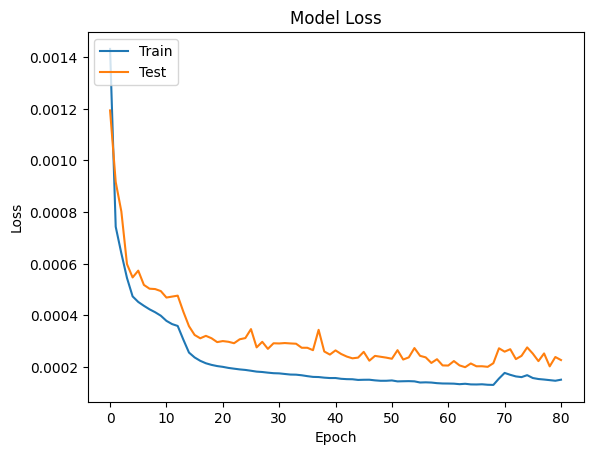

In [ ]:
# Plotting model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model_path = '/content/drive/MyDrive/Fraud analytics/autoencoder_model.pth'
autoencoder.save(model_path)

In [ ]:
from tensorflow.keras.models import load_model

model_path = '/content/drive/MyDrive/Fraud analytics/autoencoder_model.pth'
# Load the model
loaded_model = load_model(model_path)

In [ ]:
predictions = autoencoder.predict(test_data)
mse = np.mean(np.power(test_data - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

904/904 [==============================] - 3s 3ms/step


,reconstruction_error,true_class
count,28924.000000,28924.000000
mean,0.044903,0.017010
std,0.003542,0.129311
min,0.026002,0.000000
25%,0.042627,0.000000
50%,0.044841,0.000000
75%,0.047057,0.000000
max,0.078152,1.000000


In [ ]:
plot_samples = 100
# normal event
real_x = test_data[:plot_samples].reshape(plot_samples, n_features)
predicted_x = autoencoder.predict(x=real_x)
normal_events_mse = losses.mean_squared_error(real_x, predicted_x)
normal_events_df = pd.DataFrame({
	'mse': normal_events_mse,
	'n': np.arange(0, plot_samples),
	'anomaly': np.zeros(plot_samples)})

abnormal_events_array = abnormal_events.values
abnormal_events_array = abnormal_events_array[:, :-1]

# abnormal event
abnormal_x = (abnormal_events_array[:plot_samples]).reshape(plot_samples, n_features)
predicted_x = autoencoder.predict(x=abnormal_x)
abnormal_events_mse = losses.mean_squared_error(abnormal_x, predicted_x)
abnormal_events_df = pd.DataFrame({
	'mse': abnormal_events_mse,
	'n': np.arange(0, plot_samples),
	'anomaly': np.ones(plot_samples)})



4/4 [==============================] - 0s 4ms/step


In [ ]:
test_data.shape

(28924, 30)

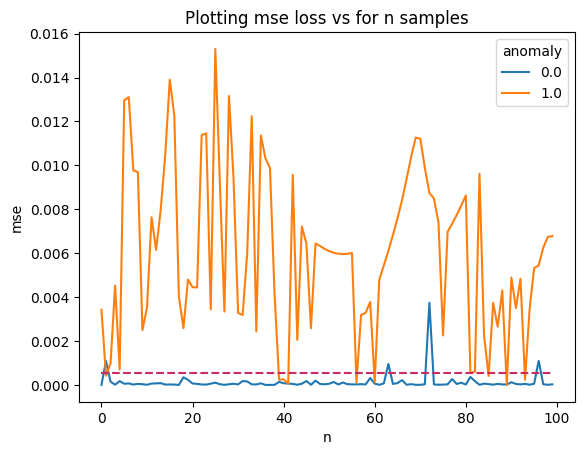

In [ ]:
mse_df = pd.concat([normal_events_df, abnormal_events_df])
plot = sns.lineplot(x=mse_df.n, y=mse_df.mse, hue=mse_df.anomaly)
cut_off = np.percentile(mse, 95)

line = lines.Line2D(
	xdata=np.arange(0, plot_samples),
	ydata=np.full(plot_samples, cut_off),
	color='#CC2B5E',
	linewidth=1.5,
	linestyle='dashed')

plot.add_artist(line)
plt.title('Plotting mse loss vs for n samples')
plt.show()

# Graphs

Text(0.5, 1.0, 'Reconstruction error without fault')

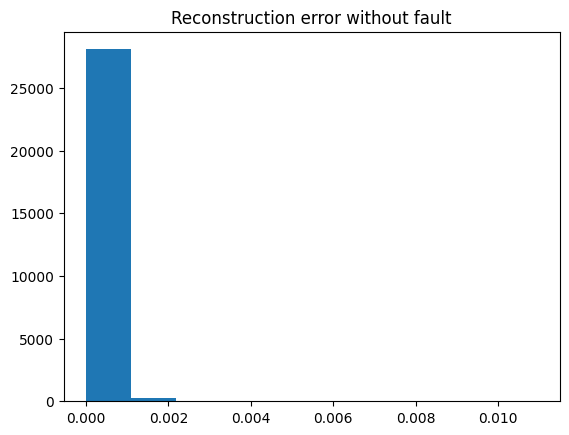

In [ ]:
# Reconstruction_error without fault

fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)
plt.title("Reconstruction error without fault")

Text(0.5, 1.0, 'Reconstruction error with fault')

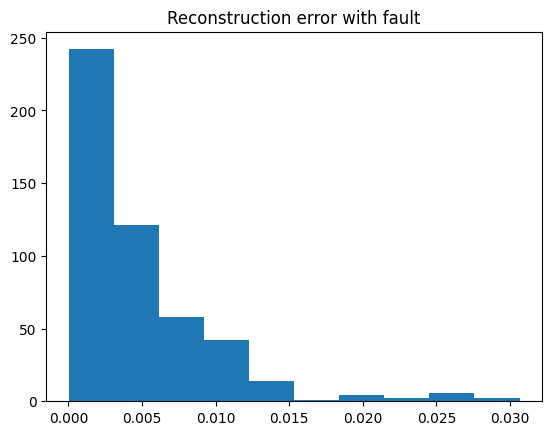

In [ ]:
# Reconstruction_error with fault

fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)
plt.title("Reconstruction error with fault")

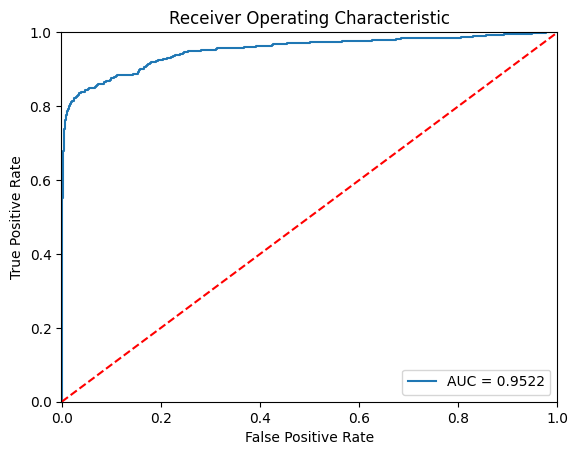

In [ ]:
# ROC curve

fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

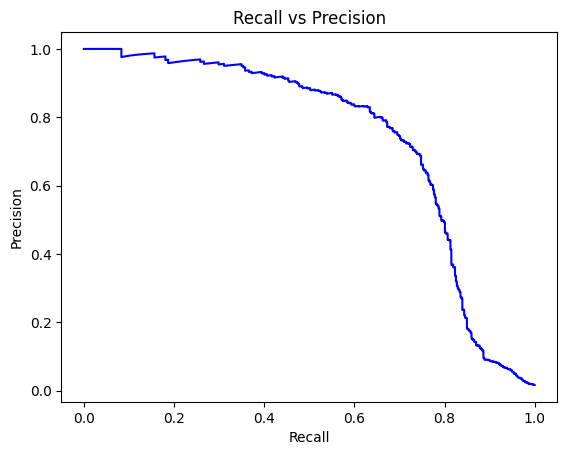

In [ ]:
# Precision and Recall

precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)

plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

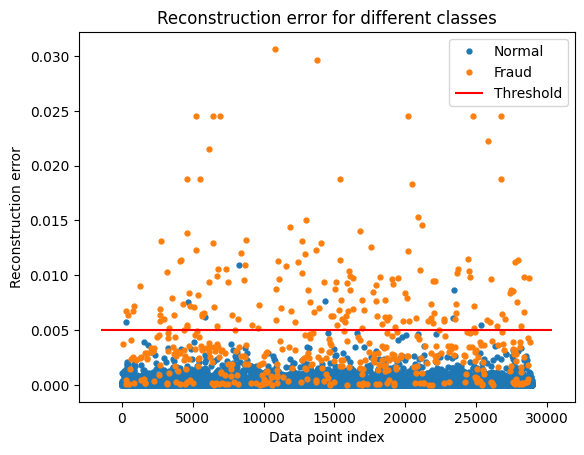

In [ ]:
# Reconstruction error for different classes

threshold = 0.005

groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')

ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

# F1 score

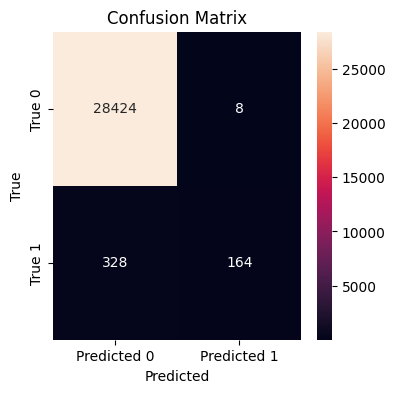

In [ ]:
# Confusion matrix

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]

cm = confusion_matrix(error_df.true_class, y_pred)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d")

# Adding labels and title
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# Adjusting ticks for better visibility
plt.xticks(ticks=[0.5, 1.5], labels=['Predicted 0', 'Predicted 1'])
plt.yticks(ticks=[0.5, 1.5], labels=['True 0', 'True 1'])

plt.show()

In [ ]:
from sklearn.metrics import f1_score

f1 = f1_score(error_df.true_class, y_pred)
f1

In [ ]:
count_ones = sum(1 for i in y_test if i == 1)
count_ones

492

# Variational Autoencoders

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, metrics
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras import layers, Model, losses
from keras.layers import Input, Dense, Lambda


In [ ]:
# Variational Autoencoder (VAE)

latent_dim = 14  # Dimensionality of the latent space

# Encoder
encoder_inputs = keras.Input(shape=(n_features,))
x = layers.Dense(64, activation='relu')(encoder_inputs)
x = layers.Dense(32, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

# Sampling from the latent distribution
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Reparameterization trick
z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(32, activation='relu')(latent_inputs)
x = layers.Dense(64, activation='relu')(x)
decoder_outputs = layers.Dense(n_features, activation = 'sigmoid')(x)


# VAE model
encoder = tf.keras.Model(inputs=encoder_inputs, outputs=z, name='encoder')
decoder = tf.keras.Model(inputs=latent_inputs, outputs=decoder_outputs, name='decoder')

# Connecting encoder and decoder
outputs = decoder(encoder(encoder_inputs))

# VAE model
vae = tf.keras.Model(inputs=encoder_inputs, outputs=outputs, name='vae')

In [ ]:
# VAE loss
reconstruction_loss = tf.keras.losses.mse(encoder_inputs, outputs)
reconstruction_loss *= n_features
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

# Compile VAE
vae.compile(optimizer='adam')

# Training the VAE model
es = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=20, restore_best_weights=True)
history = vae.fit(x=train_data, y=train_data, epochs=100, verbose=1, validation_data=[test_data, test_data], callbacks=[es])

Epoch 1/100
7997/7997 [==============================] - 30s 4ms/step - loss: 0.0876 - val_loss: 0.0896
Epoch 2/100
7997/7997 [==============================] - 30s 4ms/step - loss: 0.0796 - val_loss: 0.0896
Epoch 3/100
7997/7997 [==============================] - 35s 4ms/step - loss: 0.0796 - val_loss: 0.0896
Epoch 4/100
7997/7997 [==============================] - 30s 4ms/step - loss: 0.0795 - val_loss: 0.0896
Epoch 5/100
7997/7997 [==============================] - 30s 4ms/step - loss: 0.0795 - val_loss: 0.0896
Epoch 6/100
7997/7997 [==============================] - 30s 4ms/step - loss: 0.0795 - val_loss: 0.0895
Epoch 7/100
7997/7997 [==============================] - 29s 4ms/step - loss: 0.0795 - val_loss: 0.0895
Epoch 8/100
7997/7997 [==============================] - 29s 4ms/step - loss: 0.0795 - val_loss: 0.0895
Epoch 9/100
7997/7997 [==============================] - 28s 4ms/step - loss: 0.0795 - val_loss: 0.0895
Epoch 10/100
7997/7997 [==============================] - 29s 4m

In [ ]:
model_path2 = '/content/drive/MyDrive/Fraud analytics/variational_autoencoder_model.pth'
vae.save(model_path2)

In [ ]:
from tensorflow.keras.models import load_model

model_path2 = '/content/drive/MyDrive/Fraud analytics/variational_autoencoder_model.pth'
# Load the model
loaded_model2 = load_model(model_path2)

In [ ]:
# VAE
encoded_test = vae.encoder(test_data)                      # Get the latent representation
decoded_test = vae.decoder(encoded_test)
reconstruction_errors = np.sum((test_data - decoded_test) ** 2, axis=1)

loss_df = pd.DataFrame({'reconstruction_errors': reconstruction_errors,
                        'true_class': y_test})


In [ ]:
loss_df.describe()

,reconstruction_errors,true_class
count,28924.000000,28924.000000
mean,0.089470,0.017010
std,0.125957,0.129311
min,0.010297,0.000000
25%,0.044828,0.000000
50%,0.069304,0.000000
75%,0.101104,0.000000
max,2.532788,1.000000


# Graphs

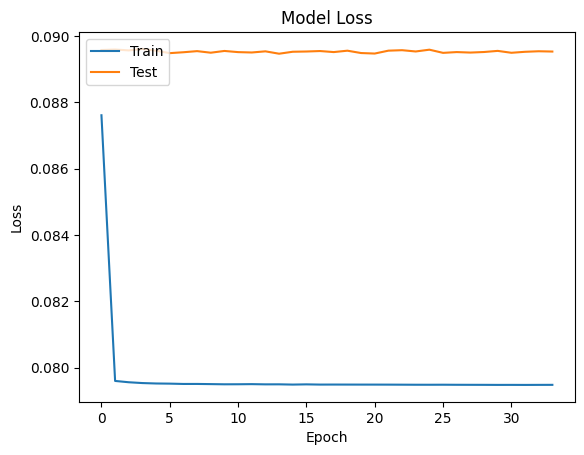

In [ ]:
# Plotting model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

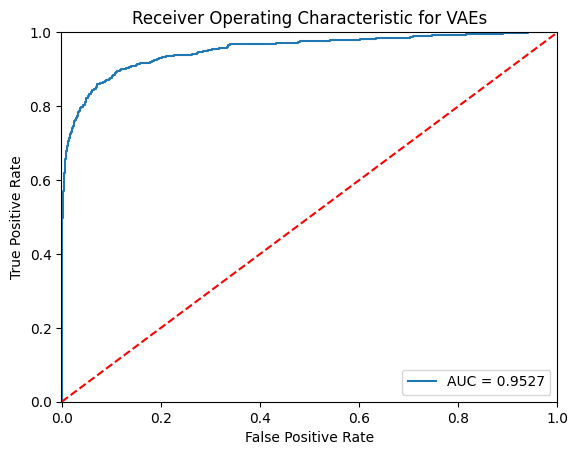

In [ ]:
# ROC curve

fpr, tpr, thresholds = roc_curve(loss_df.true_class, loss_df.reconstruction_errors)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic for VAEs')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

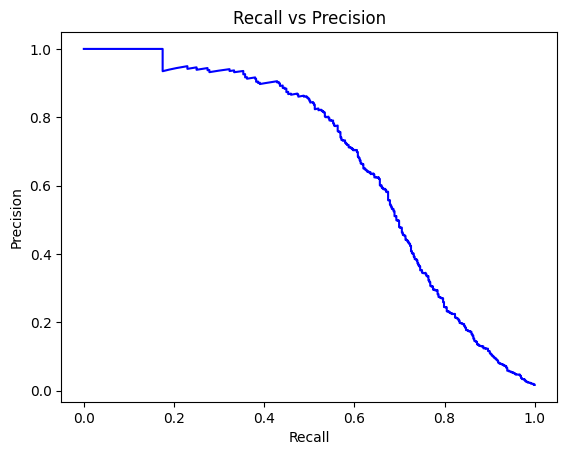

In [ ]:
# Precision and Recall

precision, recall, th = precision_recall_curve(loss_df.true_class, loss_df.reconstruction_errors)

plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

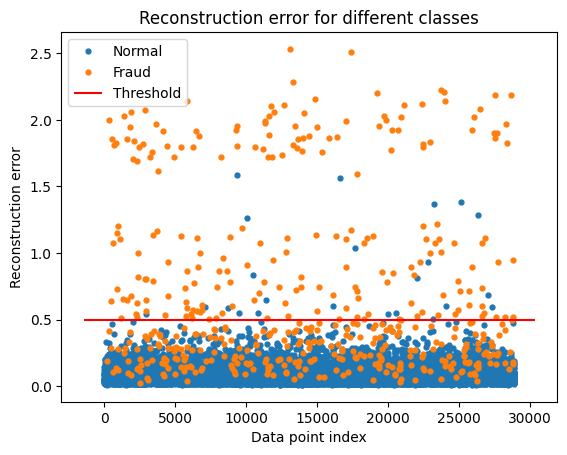

In [ ]:
# Reconstruction error for different classes

threshold = 0.5

groups = loss_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_errors, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')

ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

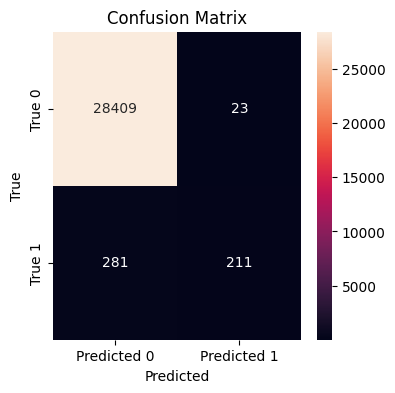

In [ ]:
# Confusion matrix

y_pred = [1 if e > threshold else 0 for e in loss_df.reconstruction_errors.values]

cm = confusion_matrix(loss_df.true_class, y_pred)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d")

# Adding labels and title
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# Adjusting ticks for better visibility
plt.xticks(ticks=[0.5, 1.5], labels=['Predicted 0', 'Predicted 1'])
plt.yticks(ticks=[0.5, 1.5], labels=['True 0', 'True 1'])

plt.show()

In [ ]:
from sklearn.metrics import f1_score

f1 = f1_score(loss_df.true_class, y_pred)
f1

0.581267217630854

In [ ]:
# CLASSIFICATION REPORT

from sklearn.metrics import classification_report
print(classification_report(loss_df.true_class, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     28432
         1.0       0.90      0.43      0.58       492

    accuracy                           0.99     28924
   macro avg       0.95      0.71      0.79     28924
weighted avg       0.99      0.99      0.99     28924

